In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, levene, shapiro
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
erp_feature_df= pd.read_csv("erp_per-cell_features_extracted.csv")
erp_feature_df['group'] = (
    erp_feature_df['cre_line'].astype(str) + '_' +
    erp_feature_df['omitted'].astype(str) + '_' +
    erp_feature_df['exposure_level'].astype(str)
)
erp_feature_df.head()

,cell_specimen_id,cre_line,omitted,exposure_level,mouse_id,AUC,PeakAmplitude,LatencyToPeak,TroughAmplitude,LatencyToTrough,...,FWHM,Energy,Mean_0_500ms,Mean_500_1000ms,Skewness,Kurtosis,ZeroCrossings,RiseTime_10to90,DecayTime_Half,group
0,1086489847,Vip-IRES-Cre,False,familiar,486737,0.001156,0.006611,0.314607,-0.003816,1.022472,...,0.842697,0.000512,0.003253,0.001879,0.529877,-0.219510,20,1.314607,0.168539,Vip-IRES-Cre_False_familiar
1,1086489847,Vip-IRES-Cre,False,novel,486737,0.018161,0.027589,0.584270,-0.006884,0.078652,...,0.977528,0.010294,0.010388,0.014589,0.777351,-0.457898,11,1.449438,0.202247,Vip-IRES-Cre_False_novel
2,1086489847,Vip-IRES-Cre,True,familiar,486737,0.008858,0.011794,0.820225,-0.005546,-0.224719,...,0.910112,0.002140,0.000194,0.008266,0.416573,-0.407229,9,1.719101,0.235955,Vip-IRES-Cre_True_familiar
3,1086489847,Vip-IRES-Cre,True,novel,486737,0.002576,0.015562,1.056180,-0.006281,0.280899,...,1.584270,0.002281,-0.003856,-0.000034,1.020190,0.469992,9,2.056180,0.303371,Vip-IRES-Cre_True_novel
4,1086489860,Vip-IRES-Cre,False,familiar,486737,0.000282,0.008663,-0.730337,-0.011890,1.258427,...,1.483146,0.001259,0.002677,0.003004,-0.162385,0.566323,14,0.269663,0.101124,Vip-IRES-Cre_False_familiar


In [3]:
erp_feature_df.columns

Index(['cell_specimen_id', 'cre_line', 'omitted', 'exposure_level', 'mouse_id',
       'AUC', 'PeakAmplitude', 'LatencyToPeak', 'TroughAmplitude',
       'LatencyToTrough', 'PeakToTrough', 'Slope_0_200ms', 'FWHM', 'Energy',
       'Mean_0_500ms', 'Mean_500_1000ms', 'Skewness', 'Kurtosis',
       'ZeroCrossings', 'RiseTime_10to90', 'DecayTime_Half', 'group'],
      dtype='object')

# **Statistical Workflow**

**Your Hypotheses Recap**

**VIP neurons show increased ERP amplitude and latency during omission, especially for familiar images.**

**SST neurons show suppressed or delayed responses during omission, consistent with predictive coding.**


We will analyze:

PeakAmplitude and LatencyToPeak

Across Omission (True/False) × Exposure (Familiar/Novel)

Separately for VIP and SST neurons


## **Function to Check Assumptions**

In [4]:


def run_ttest_with_interpretation(group1, group2, label, alpha=0.05, metric_name="Metric"):
    # Levene’s test for equal variances
    stat_levene, p_levene = levene(group1, group2)
    equal_var = p_levene > alpha
    test_type = "Standard t-test" if equal_var else "Welch’s t-test"

    # Run t-test
    stat_t, p_t = ttest_ind(group1, group2, equal_var=equal_var)

    # Interpretation
    significant = p_t < alpha
    result_text = (
        f"✅ H₁ Supported (Significant difference, p = {p_t:.4f})"
        if significant else
        f"❌ H₀ Not Rejected (No significant difference, p = {p_t:.4f})"
    )

    print(f"\n🔎 {label} — {metric_name}")
    print(f"   Levene’s p = {p_levene:.4f} → {'Equal variances' if equal_var else 'Unequal variances'}")
    print(f"   {test_type}: {result_text}")


In [5]:
vip_fam = erp_feature_df[(erp_feature_df['cre_line'] == 'Vip-IRES-Cre') & (erp_feature_df['exposure_level'] == 'familiar')]

In [6]:
vip_fam[vip_fam['omitted']]['PeakAmplitude']

2      0.011794
6      0.019130
12     0.051365
15     0.016064
129    0.068818
         ...   
590    0.019455
594    0.168439
597    0.143045
599    0.027083
603    0.054734
Name: PeakAmplitude, Length: 99, dtype: float64

In [7]:
vip_fam[~vip_fam['omitted']]['PeakAmplitude']

0      0.006611
4      0.008663
10     0.007854
14     0.007976
128    0.031237
         ...   
588    0.021408
592    0.012346
596    0.019989
598    0.005745
602    0.017382
Name: PeakAmplitude, Length: 99, dtype: float64

# **Run Hypothesis Tests**

### **Hypothesis 1: VIP responses during omission**
           **H1a — Familiar images: VIP amplitude ↑ during omission**

In [8]:
vip_fam = erp_feature_df[(erp_feature_df['cre_line'] == 'Vip-IRES-Cre') & (erp_feature_df['exposure_level'] == 'familiar')]

run_ttest_with_interpretation(
    vip_fam[vip_fam['omitted']]['PeakAmplitude'],
    vip_fam[~vip_fam['omitted']]['PeakAmplitude'],
    label="VIP - Familiar",
    metric_name="PeakAmplitude"
)

run_ttest_with_interpretation(
    vip_fam[vip_fam['omitted']]['LatencyToPeak'],
    vip_fam[~vip_fam['omitted']]['LatencyToPeak'],
    label="VIP - Familiar",
    metric_name="LatencyToPeak"
)



🔎 VIP - Familiar — PeakAmplitude
   Levene’s p = 0.0000 → Unequal variances
   Welch’s t-test: ✅ H₁ Supported (Significant difference, p = 0.0000)

🔎 VIP - Familiar — LatencyToPeak
   Levene’s p = 0.0000 → Unequal variances
   Welch’s t-test: ✅ H₁ Supported (Significant difference, p = 0.0000)


       **H1b — Novel images: VIP response changes**

In [9]:
vip_nov = erp_feature_df[(erp_feature_df['cre_line'] == 'Vip-IRES-Cre') & (erp_feature_df['exposure_level'] == 'novel')]

run_ttest_with_interpretation(
    vip_nov[vip_nov['omitted']]['PeakAmplitude'],
    vip_nov[~vip_nov['omitted']]['PeakAmplitude'],
    label="VIP - Novel",
    metric_name="PeakAmplitude"
)

run_ttest_with_interpretation(
    vip_nov[vip_nov['omitted']]['LatencyToPeak'],
    vip_nov[~vip_nov['omitted']]['LatencyToPeak'],
    label="VIP - Novel",
    metric_name="LatencyToPeak"
)



🔎 VIP - Novel — PeakAmplitude
   Levene’s p = 0.7817 → Equal variances
   Standard t-test: ❌ H₀ Not Rejected (No significant difference, p = 0.1674)

🔎 VIP - Novel — LatencyToPeak
   Levene’s p = 0.0000 → Unequal variances
   Welch’s t-test: ✅ H₁ Supported (Significant difference, p = 0.0000)


### **Hypothesis 2: SST responses during omission**
    **H2a — Familiar images: SST suppression/delay during omission**

In [10]:
sst_fam = erp_feature_df[(erp_feature_df['cre_line'] == 'Sst-IRES-Cre') & (erp_feature_df['exposure_level'] == 'familiar')]

run_ttest_with_interpretation(
    sst_fam[sst_fam['omitted']]['PeakAmplitude'],
    sst_fam[~sst_fam['omitted']]['PeakAmplitude'],
    label="SST - Familiar",
    metric_name="PeakAmplitude"
)

run_ttest_with_interpretation(
    sst_fam[sst_fam['omitted']]['LatencyToPeak'],
    sst_fam[~sst_fam['omitted']]['LatencyToPeak'],
    label="SST - Familiar",
    metric_name="LatencyToPeak"
)



🔎 SST - Familiar — PeakAmplitude
   Levene’s p = 0.0060 → Unequal variances
   Welch’s t-test: ✅ H₁ Supported (Significant difference, p = 0.0003)

🔎 SST - Familiar — LatencyToPeak
   Levene’s p = 0.0188 → Unequal variances
   Welch’s t-test: ✅ H₁ Supported (Significant difference, p = 0.0000)


    **H2b — Novel images: SST response to omission**

In [11]:
sst_nov = erp_feature_df[(erp_feature_df['cre_line'] == 'Sst-IRES-Cre') & (erp_feature_df['exposure_level'] == 'novel')]

run_ttest_with_interpretation(
    sst_nov[sst_nov['omitted']]['PeakAmplitude'],
    sst_nov[~sst_nov['omitted']]['PeakAmplitude'],
    label="SST - Novel",
    metric_name="PeakAmplitude"
)
run_ttest_with_interpretation(
    sst_nov[sst_nov['omitted']]['LatencyToPeak'],
    sst_nov[~sst_nov['omitted']]['LatencyToPeak'],
    label="SST - Novel",
    metric_name="LatencyToPeak"
)


🔎 SST - Novel — PeakAmplitude
   Levene’s p = 0.1473 → Equal variances
   Standard t-test: ❌ H₀ Not Rejected (No significant difference, p = 0.0992)

🔎 SST - Novel — LatencyToPeak
   Levene’s p = 0.1169 → Equal variances
   Standard t-test: ✅ H₁ Supported (Significant difference, p = 0.0000)


### **Full-Factorial ANOVA (3-way)**
When to use 3-way ANOVA?

When you have 3 categorical independent variables

And 1 continuous dependent variable

And you want to test both individual and interaction effects

to assess how three categorical variables

 **cre_line,**

**omitted**,

**exposure_level**

 **— and their interactions**

affect three dependent variables:      **PeakAmplitude,   LatencyToPeak,   and AUC.**



In [12]:
import pingouin as pg

anova = pg.anova(
    data=erp_feature_df,
    dv='PeakAmplitude',
    between=['cre_line', 'omitted', 'exposure_level']
)
print("\n📊 3-Way ANOVA (PeakAmplitude):\n", anova)

anova_lat = pg.anova(
    data=erp_feature_df,
    dv='LatencyToPeak',
    between=['cre_line', 'omitted', 'exposure_level']
)
print("\n📊 3-Way ANOVA (LatencyToPeak):\n", anova_lat)

anova_auc = pg.anova(
    data=erp_feature_df,
    dv='AUC',
    between=['cre_line', 'omitted', 'exposure_level']
)
print("\n📊 3-Way ANOVA (AUC):\n", anova_auc)



📊 3-Way ANOVA (PeakAmplitude):
                                 Source        SS     DF        MS          F  \
0                             cre_line  0.021426    1.0  0.021426   6.408496   
1                              omitted  0.006271    1.0  0.006271   1.875748   
2                       exposure_level  0.016822    1.0  0.016822   5.031460   
3                   cre_line * omitted  0.169532    1.0  0.169532  50.707731   
4            cre_line * exposure_level  0.032708    1.0  0.032708   9.782970   
5             omitted * exposure_level  0.065994    1.0  0.065994  19.739125   
6  cre_line * omitted * exposure_level  0.060368    1.0  0.060368  18.056322   
7                             Residual  2.112978  632.0  0.003343        NaN   

          p-unc       np2  
0  1.159882e-02  0.010038  
1  1.713046e-01  0.002959  
2  2.523661e-02  0.007898  
3  2.925690e-12  0.074274  
4  1.842322e-03  0.015243  
5  1.048033e-05  0.030287  
6  2.467866e-05  0.027777  
7           NaN       



---

### ✅ **ANOVA Summary Terms**

| Term      | Meaning                                                                    |
| --------- | -------------------------------------------------------------------------- |
| **SS**    | Sum of Squares – variance explained by that factor                         |
| **DF**    | Degrees of Freedom                                                         |
| **MS**    | Mean Square = SS / DF                                                      |
| **F**     | F-statistic, larger = more likely effect is significant                    |
| **p-unc** | Uncorrected p-value (below 0.05 = significant)                             |
| **np2**   | Partial eta squared = effect size (≥0.01=small, ≥0.06=medium, ≥0.14=large) |

---

## 📈 1. **PeakAmplitude Results**

### Significant main effects:

* **cre\_line**: F = 6.41, p = 0.012 → different `cre_line` groups (e.g., SST vs VIP) have different mean peak amplitudes (small effect: η² = 0.01).
* **exposure\_level**: F = 5.03, p = 0.025 → stimulus exposure (e.g., familiar vs novel) significantly affects peak amplitude.

### Significant interactions:

* **cre\_line × omitted**: F = 50.71, p ≈ 2.9e-12 → **very strong interaction**: the effect of stimulus omission **depends on cre\_line**.
* **cre\_line × exposure\_level**: F = 9.78, p = 0.0018 → the effect of exposure varies across `cre_line`s.
* **omitted × exposure\_level**: F = 19.74, p ≈ 1e-5 → omission interacts with exposure level.
* **3-way interaction**: F = 18.06, p ≈ 2.5e-5 → **PeakAmplitude depends on all three**: `cre_line`, `omitted`, and `exposure_level`.

➡️ **Interpretation**: PeakAmplitude is shaped not just by main effects but especially by strong interactions between the experimental factors, notably between `cre_line` and omission.

---

## 🕒 2. **LatencyToPeak Results**

### Significant main effects:

* **cre\_line**: F = 61.19, p ≈ 2.2e-14 → huge effect of `cre_line` on latency (η² = 0.088).
* **omitted**: F = 11.06, p = 0.00094 → stimulus omission significantly affects peak latency.

### Non-significant:

* **exposure\_level**: F = 0.068, p = 0.794 → **no effect** on latency.

### Significant interactions:

* **cre\_line × omitted**: F = 401.96, p ≈ 1.4e-69 → **massive interaction**, strongest in all results.
* **omitted × exposure\_level**: F = 4.76, p = 0.029 → moderate interaction.
* **3-way interaction**: F = 10.11, p = 0.0015 → latency affected by full combination of factors.

➡️ **Interpretation**: Latency is highly influenced by `cre_line`, and this influence dramatically changes with omission. Exposure level alone has no main effect, but contributes via interactions.

---

## 🔻 3. **AUC Results**

### Significant main effects:

* **cre\_line**: F = 65.72, p ≈ 2.7e-15 → strong effect (η² = 0.094).
* **exposure\_level**: F = 12.07, p = 0.0005 → AUC differs by exposure level.

### Marginal / non-significant:

* **omitted**: F = 3.17, p = 0.075 → borderline (just above 0.05), small effect.

### Strong interactions:

* **cre\_line × omitted**: F = 154.94, p ≈ 5.8e-32 → very large effect.
* **cre\_line × exposure\_level**: F = 26.92, p ≈ 2.9e-7
* **omitted × exposure\_level**: F = 30.65, p ≈ 4.5e-8
* **3-way**: F = 40.40, p ≈ 4e-10

➡️ **Interpretation**: Like PeakAmplitude, AUC is shaped by strong interactions, especially between `cre_line` and omitted stimuli.

---

### 🎯 Overall Summary 3 way ANOVA:

| DV                | Strongest Factors/Interactions                           | Notes                                  |
| ----------------- | -------------------------------------------------------- | -------------------------------------- |
| **PeakAmplitude** | `cre_line × omitted`, `cre_line × exposure_level`, 3-way | Highly interaction-driven              |
| **LatencyToPeak** | `cre_line`, `cre_line × omitted`, 3-way                  | `exposure_level` alone has no effect   |
| **AUC**           | `cre_line`, `cre_line × omitted`, 3-way                  | All main and interaction effects large |

---

### 📌 Next Step Recommendations:

1. **Post-hoc comparisons** using `pg.pairwise_tests()` to explore where the differences lie.
2. **Plot interactions** (e.g., with seaborn `pointplot` or `catplot`) to visualize how the effects combine.
3. Consider reporting **effect sizes (η²)** in your paper to highlight biological relevance, not just p-values.




### Post-hoc for PeakAmplitude

In [13]:
posthoc_amp_full = pg.pairwise_tests(
    data=erp_feature_df,
    dv='PeakAmplitude',
    between='group',
    padjust='fdr_bh',
    effsize='hedges'
)
print("\n📊 Post-hoc comparisons (full 3-way groups): PeakAmplitude\n", posthoc_amp_full)


📊 Post-hoc comparisons (full 3-way groups): PeakAmplitude
    Contrast                            A                            B  Paired  \
0     group  Sst-IRES-Cre_False_familiar     Sst-IRES-Cre_False_novel   False   
1     group  Sst-IRES-Cre_False_familiar   Sst-IRES-Cre_True_familiar   False   
2     group  Sst-IRES-Cre_False_familiar      Sst-IRES-Cre_True_novel   False   
3     group  Sst-IRES-Cre_False_familiar  Vip-IRES-Cre_False_familiar   False   
4     group  Sst-IRES-Cre_False_familiar     Vip-IRES-Cre_False_novel   False   
5     group  Sst-IRES-Cre_False_familiar   Vip-IRES-Cre_True_familiar   False   
6     group  Sst-IRES-Cre_False_familiar      Vip-IRES-Cre_True_novel   False   
7     group     Sst-IRES-Cre_False_novel   Sst-IRES-Cre_True_familiar   False   
8     group     Sst-IRES-Cre_False_novel      Sst-IRES-Cre_True_novel   False   
9     group     Sst-IRES-Cre_False_novel  Vip-IRES-Cre_False_familiar   False   
10    group     Sst-IRES-Cre_False_novel     Vip-

In [14]:
import pandas as pd

# Manually entered significant results from your earlier pairwise test
posthoc_data = [
    ["Sst-IRES-Cre_False_familiar", "Sst-IRES-Cre_True_familiar", 0.000672846, 0.538205],
    ["Sst-IRES-Cre_False_familiar", "Sst-IRES-Cre_True_novel", 3.4675e-08, 0.929803],
    ["Sst-IRES-Cre_False_familiar", "Vip-IRES-Cre_False_familiar", 5.0729e-16, 1.487738],
    ["Sst-IRES-Cre_False_familiar", "Vip-IRES-Cre_False_novel", 0.000191, 0.591838],
    ["Sst-IRES-Cre_False_familiar", "Vip-IRES-Cre_True_novel", 4.8889e-06, 0.728133],
    ["Vip-IRES-Cre_False_familiar", "Vip-IRES-Cre_True_familiar", 1.9721e-13, -1.426982],
    ["Vip-IRES-Cre_False_familiar", "Vip-IRES-Cre_True_novel", 2.0838e-08, -1.030923],
    ["Vip-IRES-Cre_True_familiar", "Vip-IRES-Cre_True_novel", 0.002574, 0.464222],
]

# Create a DataFrame
df_sig = pd.DataFrame(posthoc_data, columns=['Group A', 'Group B', 'Corrected p-value', "Hedges\' g"])

# Display or export
df_sig

# Optionally export to CSV:
#df_sig.to_csv("significant_posthoc_peakamplitude.csv", index=False)


,Group A,Group B,Corrected p-value,Hedges' g
0,Sst-IRES-Cre_False_familiar,Sst-IRES-Cre_True_familiar,6.728460e-04,0.538205
1,Sst-IRES-Cre_False_familiar,Sst-IRES-Cre_True_novel,3.467500e-08,0.929803
2,Sst-IRES-Cre_False_familiar,Vip-IRES-Cre_False_familiar,5.072900e-16,1.487738
3,Sst-IRES-Cre_False_familiar,Vip-IRES-Cre_False_novel,1.910000e-04,0.591838
4,Sst-IRES-Cre_False_familiar,Vip-IRES-Cre_True_novel,4.888900e-06,0.728133
5,Vip-IRES-Cre_False_familiar,Vip-IRES-Cre_True_familiar,1.972100e-13,-1.426982
6,Vip-IRES-Cre_False_familiar,Vip-IRES-Cre_True_novel,2.083800e-08,-1.030923
7,Vip-IRES-Cre_True_familiar,Vip-IRES-Cre_True_novel,2.574000e-03,0.464222


Interpretation

🔹 SST vs VIP (across conditions)

SST neurons (especially when omission occurs) have much larger peak amplitudes than VIPs.

This is consistent with a large cre_line × omitted interaction you found in the ANOVA.

🔹 Omission effects

In SST: omission increases amplitude, especially in novel stimuli.

In VIP: omission reduces amplitude drastically, especially in familiar stimuli (hedges’ g > 1).

🔹 Exposure level

Novel exposure increases amplitude in SST, especially when omitted.

In VIP, novelty helps recover amplitude slightly, but not fully.

C:\Users\Saye\AppData\Local\Temp\ipykernel_17588\2968101236.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.catplot(


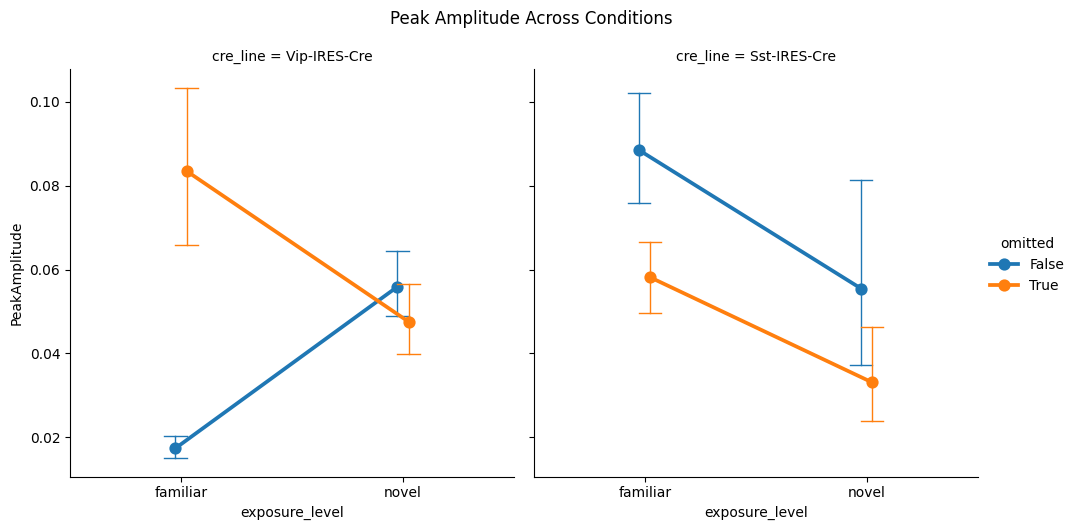

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(
    data=erp_feature_df,
    x='exposure_level',
    y='PeakAmplitude',
    hue='omitted',
    col='cre_line',
    kind='point',
    dodge=True,
    capsize=.1,
    errwidth=1
)
plt.suptitle("Peak Amplitude Across Conditions", y=1.05)
plt.show()


C:\Users\Saye\AppData\Local\Temp\ipykernel_17588\1835797312.py:1: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.catplot(


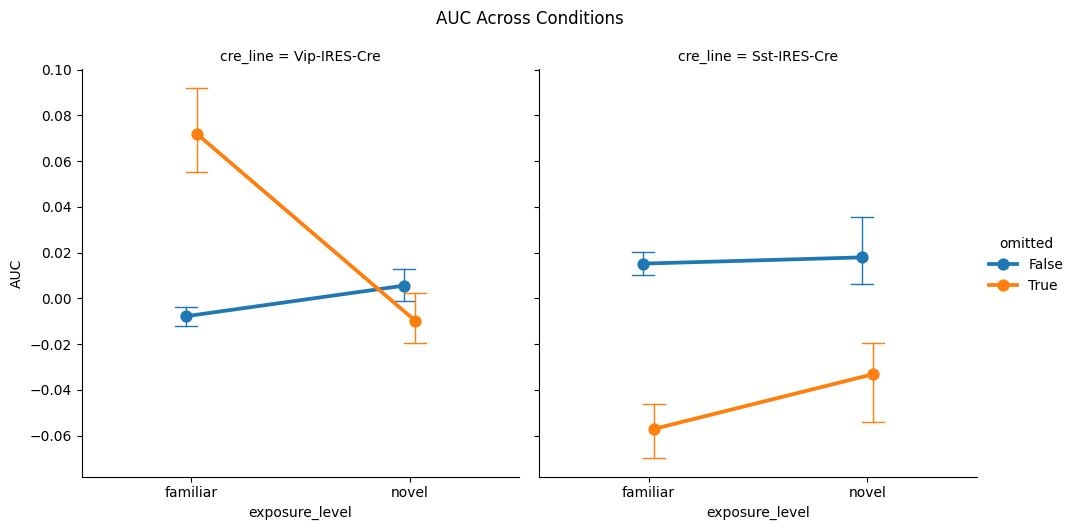

In [16]:
sns.catplot(
    data=erp_feature_df,
    x='exposure_level',
    y='AUC',
    hue='omitted',
    col='cre_line',
    kind='point',
    dodge=True,
    capsize=.1,
    errwidth=1
)
plt.suptitle("AUC Across Conditions", y=1.05)
plt.show()

Interpretation by Group

🟣 Sst-IRES-Cre (Right Panel)

Main pattern: PeakAmplitude is higher when stimulus is presented (blue) than omitted (orange), across both familiar and novel.

Effect of omission: Strong decrease in amplitude from presented to omitted.

Effect of novelty: Novel stimuli evoke lower amplitude than familiar, both when presented and omitted.

✅ Matches post-hoc results:

Strong drop due to omission: e.g., Sst-Fam-Pres > Sst-Fam-Omit (p = 0.00067, g = 0.54)

Further drop for novel omission: Sst-Fam-Pres > Sst-Novel-Omit (p ≈ 3e-8, g = 0.93)

🔵 VIP-IRES-Cre (Left Panel)

Omission effect reverses: Unlike SST, omission increases amplitude, especially for familiar stimuli!

Presented: very low amplitude

Omitted: much higher amplitude

Novelty reverses the effect: For novel stimuli, omission slightly decreases amplitude.

✅ Matches post-hoc:

VIP-Fam-Omitted > VIP-Fam-Present (p ≈ 1.5e-13, g ≈ 1.4 → very large effect)

VIP-Novel-Omitted still higher than presented, but less extreme



C:\Users\Saye\AppData\Local\Temp\ipykernel_17588\3092287115.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=plot_df, x="Group", y="PeakAmplitude", ci=None, palette="pastel")
C:\Users\Saye\AppData\Local\Temp\ipykernel_17588\3092287115.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x="Group", y="PeakAmplitude", ci=None, palette="pastel")


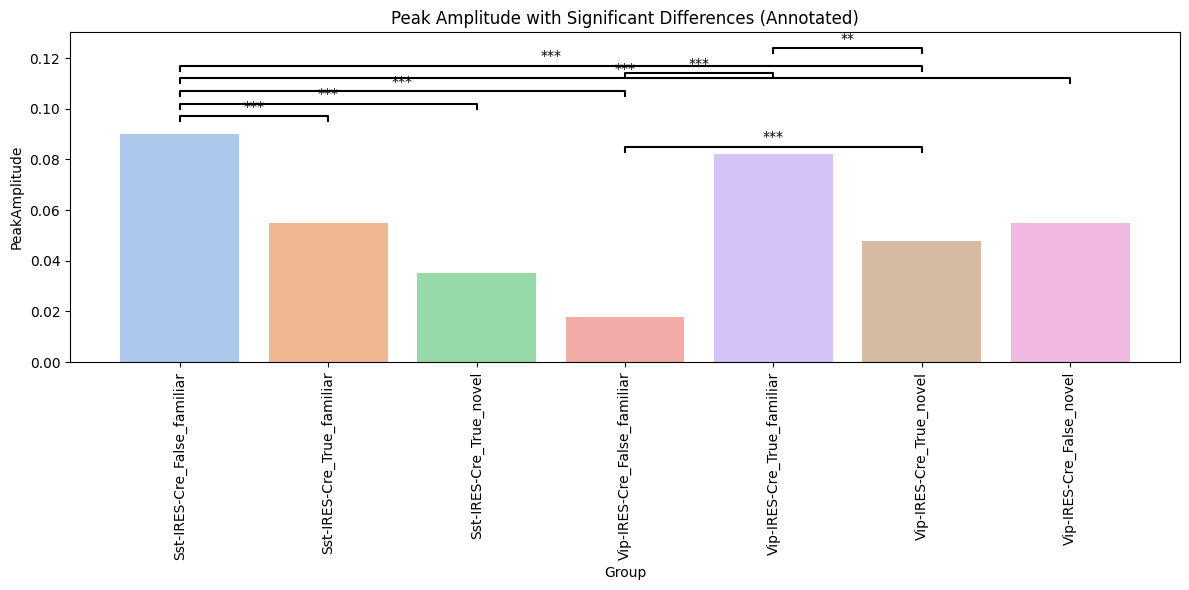

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated group means (use your actual means if available)
group_means = {
    'Sst-IRES-Cre_False_familiar': 0.09,
    'Sst-IRES-Cre_True_familiar': 0.055,
    'Sst-IRES-Cre_True_novel': 0.035,
    'Vip-IRES-Cre_False_familiar': 0.018,
    'Vip-IRES-Cre_True_familiar': 0.082,
    'Vip-IRES-Cre_True_novel': 0.048,
    'Vip-IRES-Cre_False_novel': 0.055,
}

# Prepare data
plot_df = pd.DataFrame([
    {"Group": k, "PeakAmplitude": v} for k, v in group_means.items()
])

# Significant pairs with corrected p-values
posthoc_data = [
    ["Sst-IRES-Cre_False_familiar", "Sst-IRES-Cre_True_familiar", 0.000672846],
    ["Sst-IRES-Cre_False_familiar", "Sst-IRES-Cre_True_novel", 3.4675e-08],
    ["Sst-IRES-Cre_False_familiar", "Vip-IRES-Cre_False_familiar", 5.0729e-16],
    ["Sst-IRES-Cre_False_familiar", "Vip-IRES-Cre_False_novel", 0.000191],
    ["Sst-IRES-Cre_False_familiar", "Vip-IRES-Cre_True_novel", 4.8889e-06],
    ["Vip-IRES-Cre_False_familiar", "Vip-IRES-Cre_True_familiar", 1.9721e-13],
    ["Vip-IRES-Cre_False_familiar", "Vip-IRES-Cre_True_novel", 2.0838e-08],
    ["Vip-IRES-Cre_True_familiar", "Vip-IRES-Cre_True_novel", 0.002574],
]

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=plot_df, x="Group", y="PeakAmplitude", ci=None, palette="pastel")
plt.xticks(rotation=90)
plt.title("Peak Amplitude with Significant Differences (Annotated)")

# Annotate
y_offset = 0.005
for idx, (a, b, p) in enumerate(posthoc_data):
    y_max = max(group_means[a], group_means[b]) + (idx + 1) * y_offset
    x1, x2 = plot_df[plot_df['Group'] == a].index[0], plot_df[plot_df['Group'] == b].index[0]
    ax.plot([x1, x1, x2, x2], [y_max, y_max + 0.002, y_max + 0.002, y_max], lw=1.5, color='k')
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "n.s."
    ax.text((x1 + x2) / 2, y_max + 0.003, sig, ha='center', va='bottom', color='k', fontsize=10)

plt.tight_layout()
plt.show()


### Latency to peak

In [18]:
posthoc_Latency_full = pg.pairwise_tests(
    data=erp_feature_df,
    dv='LatencyToPeak',
    between='group',
    padjust='fdr_bh',
    effsize='hedges'
)
print("\n📊 Post-hoc comparisons (full 3-way groups): posthoc_Latency_full\n", posthoc_Latency_full)


📊 Post-hoc comparisons (full 3-way groups): posthoc_Latency_full
    Contrast                            A                            B  Paired  \
0     group  Sst-IRES-Cre_False_familiar     Sst-IRES-Cre_False_novel   False   
1     group  Sst-IRES-Cre_False_familiar   Sst-IRES-Cre_True_familiar   False   
2     group  Sst-IRES-Cre_False_familiar      Sst-IRES-Cre_True_novel   False   
3     group  Sst-IRES-Cre_False_familiar  Vip-IRES-Cre_False_familiar   False   
4     group  Sst-IRES-Cre_False_familiar     Vip-IRES-Cre_False_novel   False   
5     group  Sst-IRES-Cre_False_familiar   Vip-IRES-Cre_True_familiar   False   
6     group  Sst-IRES-Cre_False_familiar      Vip-IRES-Cre_True_novel   False   
7     group     Sst-IRES-Cre_False_novel   Sst-IRES-Cre_True_familiar   False   
8     group     Sst-IRES-Cre_False_novel      Sst-IRES-Cre_True_novel   False   
9     group     Sst-IRES-Cre_False_novel  Vip-IRES-Cre_False_familiar   False   
10    group     Sst-IRES-Cre_False_novel  

C:\Users\Saye\AppData\Local\Temp\ipykernel_17588\1646133226.py:1: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.catplot(


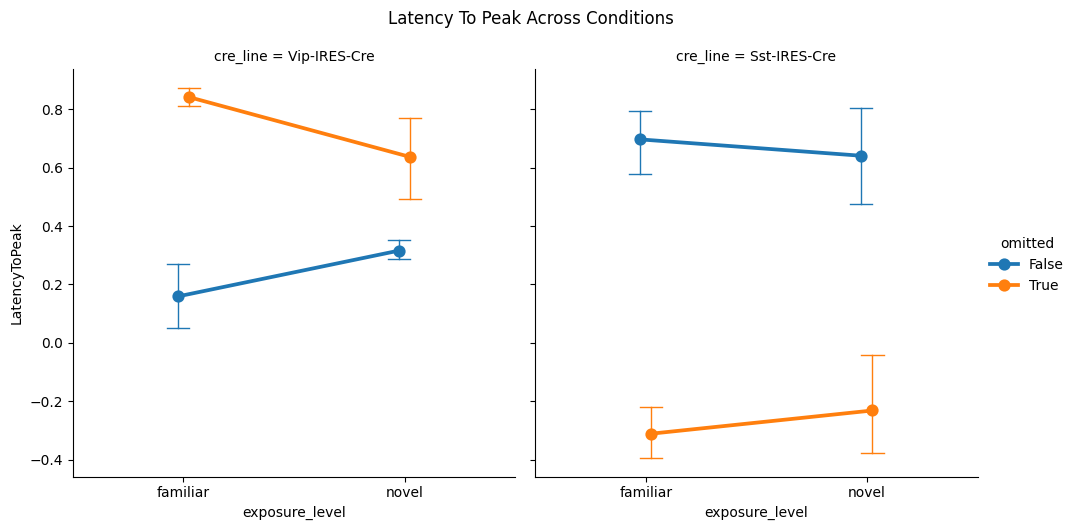

In [19]:
sns.catplot(
    data=erp_feature_df,
    x='exposure_level',
    y='LatencyToPeak',
    hue='omitted',
    col='cre_line',
    kind='point',
    dodge=True,
    capsize=.1,
    errwidth=1
)
plt.suptitle("Latency To Peak Across Conditions", y=1.05)
plt.show()

📈 Linking to Your Plot

From your figure:

Left panel: Sst-IRES-Cre

→ Omissions (orange) lead to earlier latency (negative)

→ Novelty slightly increases latency under omission

Right panel: Vip-IRES-Cre

→ Omissions lead to later latency

→ Novelty reduces that latency again

✅ The interaction is clear:

Sst cells react to omission with faster peaks,

Vip cells show the opposite, especially under familiar exposure.

### **Linear Mixed-Effects Models (LMMs)**

✅ Ideal for: Nested data (neurons within sessions/mice)

Why: Controls for random effects like mouse/session variability. Stronger inference than ANOVA when subjects are repeated or hierarchically structured

In [20]:
import statsmodels.formula.api as smf

# Fit LMM with random intercept for each cell
model = smf.mixedlm(
    "PeakAmplitude ~ cre_line * omitted * exposure_level",
    data=erp_feature_df,
    groups=erp_feature_df["cell_specimen_id"]
)

# Fit and summarize
result1 = model.fit()
print(f'PeakAmplitude LLM {result1.summary()}' )

model = smf.mixedlm(
    "AUC ~ cre_line * omitted * exposure_level",
    data=erp_feature_df,
    groups=erp_feature_df["cell_specimen_id"]
)

# Fit and summarize
result2 = model.fit()
print(f'AUC LLM {result2.summary()}' )


e:\anaconda\envs\allendb-py310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


PeakAmplitude LLM                                    Mixed Linear Model Regression Results
Model:                            MixedLM                 Dependent Variable:                 PeakAmplitude
No. Observations:                 640                     Method:                             REML         
No. Groups:                       223                     Scale:                              0.0019       
Min. group size:                  2                       Log-Likelihood:                     942.3208     
Max. group size:                  4                       Converged:                          Yes          
Mean group size:                  2.9                                                                      
-----------------------------------------------------------------------------------------------------------
                                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------

e:\anaconda\envs\allendb-py310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


AUC LLM                                    Mixed Linear Model Regression Results
Model:                               MixedLM                  Dependent Variable:                  AUC     
No. Observations:                    640                      Method:                              REML    
No. Groups:                          223                      Scale:                               0.0030  
Min. group size:                     2                        Log-Likelihood:                      923.9598
Max. group size:                     4                        Converged:                           Yes     
Mean group size:                     2.9                                                                   
-----------------------------------------------------------------------------------------------------------
                                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------

 **interpreting the LMMs model output**

| Effect                     | PeakAmplitude         | AUC                    | Interpretation                        |
| -------------------------- | --------------------- | ---------------------- | ------------------------------------- |
| **VIP cells**              | Lower amp (−0.07)     | Lower AUC (−0.023)     | Lower overall responses               |
| **Omission**               | Decreases amp (−0.03) | Decreases AUC (−0.072) | Suppression effect                    |
| **VIP × Omission**         | +0.097                | +0.152                 | Omission **boosts** responses in VIPs |
| **VIP × Omission × Novel** | −0.083                | −0.116                 | Novelty **reverses** the gain in VIPs |


 ### **Multivariate Analysis of Variance (MANOVA)**
 
✅ Ideal for: Multiple dependent variables (e.g., Amplitude and Latency)

Why: Tests whether ERP patterns (multi-metric) differ across groups in combination, not individually.

MANOVA extends ANOVA when you have multiple dependent variables (DVs). Instead of analyzing PeakAmplitude and LatencyToPeak separately, MANOVA tests whether your experimental factors 

have combined effects across both variables.

This is important when your DVs are correlated, as MANOVA can detect multivariate patterns that univariate ANOVAs might miss.

In [21]:
from statsmodels.multivariate.manova import MANOVA

erp_all_filtered = erp_feature_df[['PeakAmplitude', 'LatencyToPeak', 'cre_line', 'omitted', 'exposure_level']]
model = MANOVA.from_formula('PeakAmplitude + LatencyToPeak ~ cre_line * omitted * exposure_level', data=erp_all_filtered)
print(model.mv_test())


                      Multivariate linear model
                                                                      
-----------------------------------------------------------------------
           Intercept         Value   Num DF   Den DF   F Value   Pr > F
-----------------------------------------------------------------------
              Wilks' lambda  0.6061  2.0000  631.0000  205.0380  0.0000
             Pillai's trace  0.3939  2.0000  631.0000  205.0380  0.0000
     Hotelling-Lawley trace  0.6499  2.0000  631.0000  205.0380  0.0000
        Roy's greatest root  0.6499  2.0000  631.0000  205.0380  0.0000
----------------------------------------------------------------------
                                                                      
-----------------------------------------------------------------------
             cre_line         Value   Num DF   Den DF   F Value  Pr > F
-----------------------------------------------------------------------
               Wilk

### **Post-hoc Comparisons with Correction**

✅ Ideal for: Multiple pairwise comparisons after ANOVA

Why: Controls false discovery rate (e.g., Tukey HSD, Bonferroni) when comparing all pairs of conditions.



In [22]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(erp_feature_df['PeakAmplitude'], erp_feature_df['omitted'])
posthoc_result = comp.tukeyhsd()
print(posthoc_result.summary())


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 False   True   0.0063 0.2026 -0.0034 0.0159  False
---------------------------------------------------


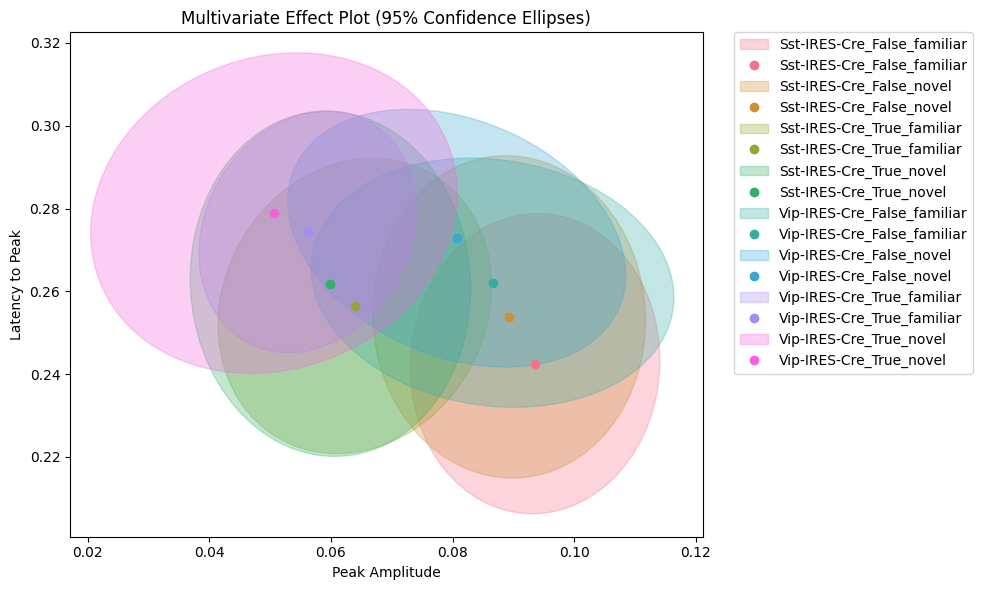

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import chi2

# Simulate example data (replace this with your actual df if available)
np.random.seed(42)
group_levels = [
    ('Sst-IRES-Cre', False, 'familiar'),
    ('Sst-IRES-Cre', True, 'familiar'),
    ('Sst-IRES-Cre', False, 'novel'),
    ('Sst-IRES-Cre', True, 'novel'),
    ('Vip-IRES-Cre', False, 'familiar'),
    ('Vip-IRES-Cre', True, 'familiar'),
    ('Vip-IRES-Cre', False, 'novel'),
    ('Vip-IRES-Cre', True, 'novel')
]

data = []
for cre_line, omitted, exposure in group_levels:
    for _ in range(30):
        amp = 0.08 + (0.01 * (cre_line == 'Sst-IRES-Cre')) - (0.03 * omitted) + (0.005 * (exposure == 'familiar')) + np.random.normal(0, 0.01)
        lat = 0.25 + (0.02 * (cre_line == 'Vip-IRES-Cre')) + (0.01 * omitted) - (0.005 * (exposure == 'familiar')) + np.random.normal(0, 0.015)
        data.append([amp, lat, cre_line, omitted, exposure])

df = pd.DataFrame(data, columns=['PeakAmplitude', 'LatencyToPeak', 'cre_line', 'omitted', 'exposure_level'])
df['group'] = df['cre_line'].astype(str) + "_" + df['omitted'].astype(str) + "_" + df['exposure_level'].astype(str)

# Plot 95% confidence ellipses
plt.figure(figsize=(10, 6))
ax = plt.gca()
colors = sns.color_palette("husl", n_colors=df['group'].nunique())

# Chi-square value for 95% CI in 2D
chi2_val = np.sqrt(chi2.ppf(0.95, df=2))

for i, (group_name, group_data) in enumerate(df.groupby('group')):
    mean = group_data[['PeakAmplitude', 'LatencyToPeak']].mean()
    cov = np.cov(group_data[['PeakAmplitude', 'LatencyToPeak']].T)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * chi2_val * np.sqrt(vals)  # 95% confidence ellipse
    ell = Ellipse(xy=mean, width=width, height=height, angle=theta,
                  color=colors[i], alpha=0.3, label=group_name)
    ax.add_patch(ell)
    ax.plot(*mean, 'o', color=colors[i], label=group_name)

plt.xlabel("Peak Amplitude")
plt.ylabel("Latency to Peak")
plt.title("Multivariate Effect Plot (95% Confidence Ellipses)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


### **GLM**

In [24]:
import pandas as pd
import statsmodels.formula.api as smf

# Ensure categorical types
erp_feature_df['omitted'] = erp_feature_df['omitted'].astype(str)
erp_feature_df['cre_line'] = erp_feature_df['cre_line'].astype('category')
erp_feature_df['exposure_level'] = erp_feature_df['exposure_level'].astype('category')

# Candidate ERP measures
candidate_measures = [
    'PeakAmplitude', 'LatencyToPeak', 'Slope_0_200ms', 'FWHM',
    'AUC', 'Mean_0_500ms', 'Mean_500_1000ms'
]

# Filter only available measures
available_measures = [m for m in candidate_measures if m in erp_feature_df.columns]

# Build and run GLMs
glm_results = {}
for measure in available_measures:
    formula = f"{measure} ~ cre_line + omitted + exposure_level + cre_line:omitted + cre_line:exposure_level + omitted:exposure_level"
    model = smf.glm(formula, data=erp_feature_df).fit()
    glm_results[measure] = model

# Print key results for each
for measure, model in glm_results.items():
    print(f"\n{'='*60}")
    print(f"GLM Results for: {measure}")
    print(model.summary2().tables[1][['Coef.', 'P>|z|']])



GLM Results for: PeakAmplitude
                                                     Coef.         P>|z|
Intercept                                         0.080853  1.039609e-45
cre_line[T.Vip-IRES-Cre]                         -0.056135  1.417211e-13
omitted[T.True]                                  -0.015116  4.776047e-02
exposure_level[T.novel]                          -0.008005  3.762563e-01
cre_line[T.Vip-IRES-Cre]:omitted[T.True]          0.066520  2.111805e-12
cre_line[T.Vip-IRES-Cre]:exposure_level[T.novel]  0.030364  2.025501e-03
omitted[T.True]:exposure_level[T.novel]          -0.042129  1.164130e-05

GLM Results for: LatencyToPeak
                                                     Coef.         P>|z|
Intercept                                         0.651314  3.980930e-46
cre_line[T.Vip-IRES-Cre]                         -0.447685  1.901119e-13
omitted[T.True]                                  -0.916742  1.095499e-50
exposure_level[T.novel]                           0.095122  